Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726'
 '[OII]3729' '[SII]6716' '[SII]6731' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
 Best Fit:       Vel     sigma
 comp.  0:        89       336
 comp.  1:       379      1000
chi2/DOF: 0.0001483; DOF: 3831; degree = -1; mdegree = 10
method = capfit; Jac calls: 7; Func calls: 107; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 12/169
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10      0.000      0.12     379  1000
Comp:  1                    H9      0.000      0.12     379  1000
Comp:  1                    H8   0.001272      0.14     379  1000
Comp:  1                  Heps  7.135e-05      0.85     379  1000
Comp:  1                Hde

Text(0.5, 1.0, 'pPXF fit with emiles SPS templates')

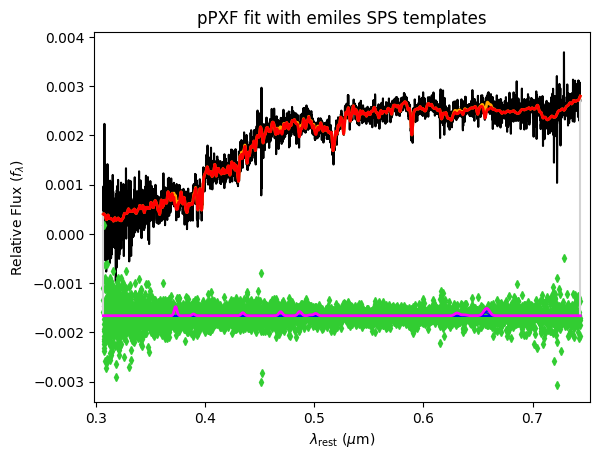

In [3]:

from time import perf_counter as clock
from pathlib import Path
from urllib import request
import numpy as np
from astropy.io import fits
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import pandas as pd
import os
import matplotlib.pyplot as plt

"""
frac = 10**wave[1]/10**wave[0]              # Constant lambda fraction per pixel
velscale = frac*c                           # Constant velocity scale in km/s per pixel
sigma_gal = 216.
sigma_gal_pxl = (sigma_gal/10**wave) * c / velscale
sigma_fin_pxl = (sigma_fin/10**wave) * c / velscale
print(min(sigma_gal_pxl), max(sigma_gal_pxl))
sigma_diff =np.sqrt(sigma_fin_pxl**2 - sigma_gal_pxl**2)
#sigma  = (sigma_fin/wave) * c / velscale
tsmooth = util.gaussian_filter1d(t, sigma_diff)


"""
"""Choosing a list of .fits files to stack:

For testing purposes we select the high dor cluster from hierarchical clustering and form a list, data, in which each element is a list of 
[wave, flux, ivar] for one spectrum

"""

files = ["cluster_results/k-means_clusters.csv", "cluster_results/gmm_clusters.csv",
         "cluster_results/hierarchical_clusters.csv"]
filename = files[2]  # selecting hierarchical for now
clusters = pd.read_csv(filename)
two = clusters[clusters["Cluster"] == 2]["SDSS_ID"].tolist()  # list of file names selecting cluster 2
one = clusters[clusters["Cluster"] == 1]["SDSS_ID"].tolist()  # selecting 1
zero = clusters[clusters["Cluster"] == 0]["SDSS_ID"].tolist()  # selecting 0

# Now we also try using actual DoR ranges
all = pd.read_csv("data/E-INSPIRE_I_master_catalogue.csv")

high = all[all['DoR'] > 0.6]
high_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits"
            for plate, mjd, fiber in zip(high['plate'], high['mjd'], high['fiberid'])]

med1 = all[all['DoR'] < 0.6]
med = med1[med1['DoR'] > 0.3]
med_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits"
           for plate, mjd, fiber in zip(med['plate'], med['mjd'], med['fiberid'])]

low = all[all['DoR'] < 0.3]
low_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits"
           for plate, mjd, fiber in zip(low['plate'], low['mjd'], low['fiberid'])]

spectra = two  # change to whichever you want
data = []


def clean_and_normalize_spectrum(wave, flux, ivar):
    # Remove NaN and inf values
    good_idx = np.isfinite(flux) & np.isfinite(ivar)
    wave, flux, ivar = wave[good_idx], flux[good_idx], ivar[good_idx]

    # Simple normalization by median flux
    median_flux = np.median(flux)

    #normalize by 5300 instead
    area = wave[wave > 5200]
    area = area[area < 5400]
    if len(area) < 1:
        print("ERROR")

    normalizing_wave = np.median(area)

    flux = flux / normalizing_wave
    ivar = ivar * (normalizing_wave ** 2)

    return wave, flux, ivar


def load_spectrum(filename):
    with fits.open(filename) as hdul:
        coadd = hdul[1].data  # Extension 1 contains the spectrum
        flux = coadd['flux']
        loglam = coadd['loglam']
        ivar = coadd['ivar']
        specobj = hdul[2].data
        z = specobj['Z'][0]

        wavelength = 10 ** loglam
        wavelength *= 1 / (1 + z)
        wavelength, flux, ivar = clean_and_normalize_spectrum(wavelength, flux, ivar)

        return wavelength, flux, ivar

filename = "fits_shortlist/spec-1619-53084-0161.fits"
wavelength, flux, ivar = load_spectrum(filename)  # data[0]



def safe_errors(stacked_ivar):
    errors = np.zeros_like(stacked_ivar)
    valid = (stacked_ivar > 0) & np.isfinite(stacked_ivar)
    errors[valid] = 1.0 / np.sqrt(stacked_ivar[valid])
    return errors


errors = safe_errors(ivar)  # use combined_ivar instead of ivar

c = 299792.458  # speed of light in km/s
lam_gal = wavelength
ln_lam_gal = np.log(lam_gal)  # Natural logarithm
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0]) / (ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c * d_ln_lam_gal  # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
factor = 0.01635
noise = np.full_like(flux, factor)  # Assume constant noise per pixel here 

dlam_gal = np.gradient(lam_gal)  # Size of every pixel in Angstroms

hdul = fits.open(filename)
coadd = hdul[1].data
wdisp = coadd['wdisp']  # assuming that the wdisp is constant between the two spectra for now.

fwhm_gal = 2.355 * wdisp * dlam_gal



# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

basename = f"spectra_{sps_name}_9.0.npz"
ppxf_dir = Path(lib.__file__).parent
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

fwhm_gal_dic = {"lam": lam_gal, "fwhm": fwhm_gal}
sps = lib.sps_lib(filename, velscale, fwhm_gal_dic)

stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

lam_range_gal = np.array([np.min(lam_gal), np.max(
    lam_gal)])  # should be 1+redshift here - what to do for stacked spectra? Using 1 as a default
gas_templates, gas_names, gas_wave = \
    util.emission_lines(sps.ln_lam_temp, lam_range_gal, fwhm_gal_dic)
templates = np.column_stack([stars_templates, gas_templates])
n_temps = stars_templates.shape[1]


component = [0] * n_temps  # Single stellar kinematic component=0 for all templates
component += [1] * len(gas_names)  # First 6 gas templates 
component = np.array(component)
moments = [2] * len(np.unique(component))  # Now this will create only 2 sets of moments (stars and gas)



vel0 = c * np.log(1)  # redshift meant to be in here too, using 1 as default?
sol = [vel0, 200]
start = [sol for j in range(len(moments))]  # adopt the same starting value for both gas and stars
degree = -1
mdegree = 10
t = clock()

pp = ppxf(templates, flux, noise, velscale, start, plot=False,  # changed "galaxy" to flux here
          moments=moments, degree=degree, mdegree=mdegree,
          lam=lam_gal, component=component,
          gas_component=component > 0, gas_names=gas_names,
          lam_temp=sps.lam_temp)

print(f"Elapsed time in pPXF: {(clock() - t):.2f}")
pp.plot()
plt.title(f"pPXF fit with {sps_name} SPS templates")